In [1]:
%matplotlib inline

#Scipy stack
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from PIL import Image, ImageDraw
import pandas as pd

from IPython.display import SVG, HTML
from pyspatial.raster import read_raster, rasterize
from pyspatial.vector import read_layer, to_shapely
from pyspatial import spatiallib as slib

In [2]:
# Let read a raster dataset.  This is the Cropland Data Layer.
# Each pixel represents a 30m x 30m area of land with a
# particular crop grown.  This is an area just east 
# of St. Louis, MO in the year 2014.
rd = read_raster("../test/data/raster/95000_45000.tif")

#Let's get all the counties in the US
url = "http://www2.census.gov/geo/tiger/GENZ2014/shp/cb_2014_us_county_500k.zip"
vl, vldf = read_layer(url, index="GEOID")

In [3]:
%%time
#Visualizing the Raster
x = rd.raster_bands #Not tiled to raster_arrays is a RasterBand
colors = rd.raster_bands.colors

# Convert the pixel values -> colors
x_rgb = slib.create_image_array(x, colors)

CPU times: user 9.06 s, sys: 36 ms, total: 9.1 s
Wall time: 9.1 s


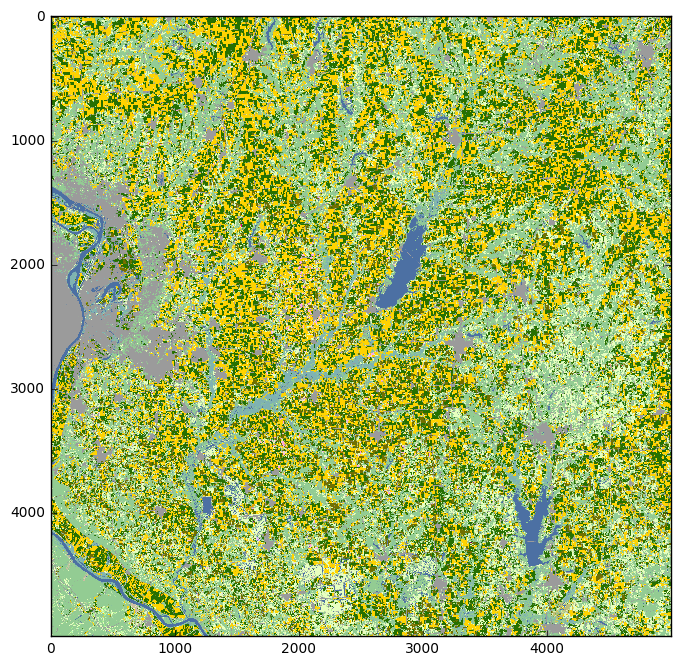

In [4]:
#Render the array as an image
plt.figure(figsize=(8, 8))
plt.imshow(x_rgb[:, :, :3])

In [5]:
# Here's the legend for the above raster
# For a list of attribute codes: http://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_nd10.htm
HTML("""<img width=500px src="http://www.sco.wisc.edu/images/stories/2012/Apr/cdl_legend_WI_2011.jpg"></img>""")

Area (acres): 17189    360963.882254
dtype: float64
Area (sq. mi): 17189    563.886296
dtype: float64


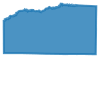

In [6]:
# Washington County, IL (fips 17189) is part of this raster,
# let's see what the shape looks like
wash_il = vl[["17189"]]

# How big is this?
print "Area (acres):", wash_il.areas(proj='albers')/4046.
print "Area (sq. mi):", wash_il.areas(proj='albers')/1.e6/2.58999

# What does the polygon look like?
SVG("<br>".join(wash_il.to_svg()))

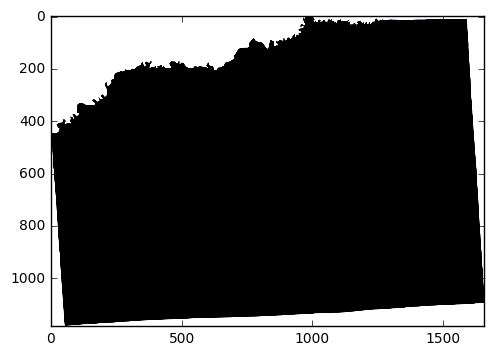

In [7]:
# Let's convert this to pixel coordinates
# The vector data will automatically be projected 
# into the raster projection, the into pixels
# using to_pixels
shp = to_shapely(rd.to_pixels(wash_il)[0])

# Let's now rasterize it into an image
plt.imshow(rasterize(shp), cmap=plt.cm.bone_r)

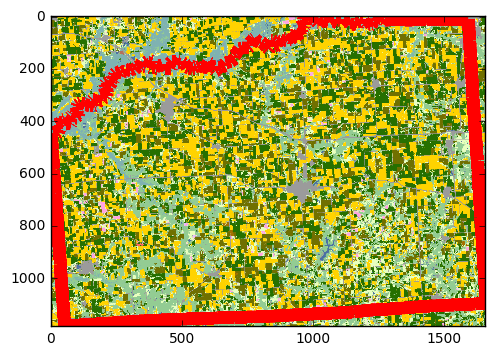

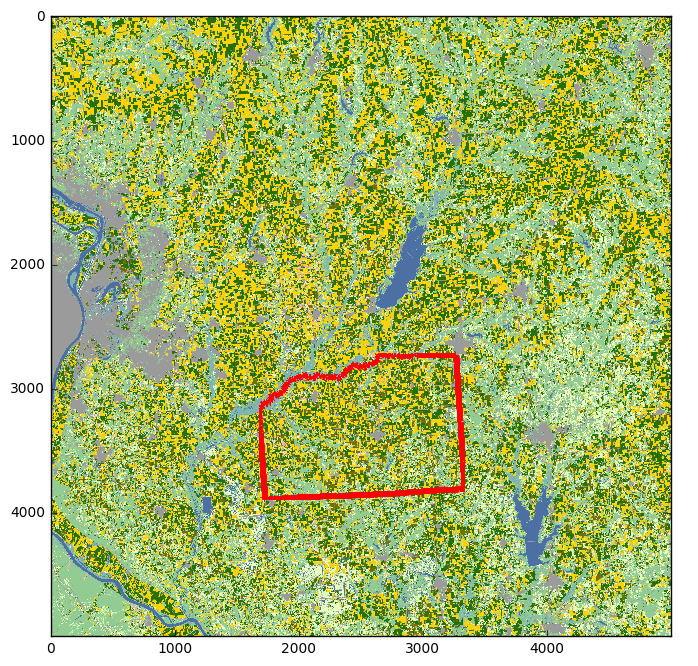

In [8]:
#Just making a copy of the image for
#Comparison purposes
x_rgb2 = x_rgb.copy()
minx, miny, maxx, maxy = map(int, shp.bounds)

# Create an outline of the county
def get_outline(shp):
    minx, miny, maxx, maxy = map(int, shp.bounds)
    width = maxx - minx
    height = maxy - miny
    im = Image.new('RGBA', (width, height), (0, 0, 0, 0)) 
    draw = ImageDraw.Draw(im) 
    shp_line = reduce(lambda x, y: x+y, [[x-minx, y-miny] for x, y in shp.exterior.coords])
    draw.line(shp_line, width=50, fill='white')
    return rgb2gray(np.array(im))

# Color it red
mask = get_outline(shp).T
pts = (np.argwhere(mask>0) + np.array([minx, miny])).astype(int)
for pt in pts:
    x_rgb2[pt[1], pt[0]] = np.array([255, 0, 0, 255])
   
# Let's first get a zoomed in version of the image
# Overlayed on the raster
plt.imshow(x_rgb2[miny:maxy, minx:maxx, :3])

# Now let's look at it on the raster
x_rgb3 = x_rgb.copy()

#Let's place a box on the image location
plt.figure(figsize=(8,8))

pts = (np.argwhere(mask>0) + np.array([minx, miny])).astype(int)
for pt in pts:
    x_rgb3[pt[1], pt[0]] = np.array([255, 0, 0, 255])

plt.imshow(x_rgb3[:, :, :3])

In [9]:
# Let's try to answer a question: How much corn and soy was grown?
# Here the weights is the fraction of the polygon in a pixel
for r in rd.query(wash_il):
    total_pixels = r.values.shape[0]
    corn = r.values==1
    soy = r.values==5
    
    print "Corn acres:", (corn*r.weights).sum() * 30 * 30 / 4046
    print "Soy acres", (soy*r.weights).sum() * 30 * 30 / 4046
    
# You can compare the answers to what you see here:
# http://nassgeodata.gmu.edu/CropScape/
# Corn: 92,280.4 ac.
# Soy: 83,030 ac.

Corn acres: 92275.9978992
Soy acres 83033.1052274
